# Dogs vs. Cats

In [1]:
/.keras/models

SyntaxError: invalid syntax (<ipython-input-1-c39d49f5532e>, line 1)

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
%matplotlib inline

import numpy as np
import keras
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array

/home/anton/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
IMG_SIZE = (224, 224)  # размер входного изображения сети
input_shape = (224, 224, 3)

## Функции загрузки данных

In [3]:
!ls ./all/

sample_submission.csv  test  train


In [4]:
import re
from random import shuffle
from glob import glob

train_files = glob('./all/train/*.jpg')
test_files = glob('./all/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)  # предобработка для VGG16

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=32):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if re.match('.*/dog\.\d', path) else 0. for path in files[i:j]])
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

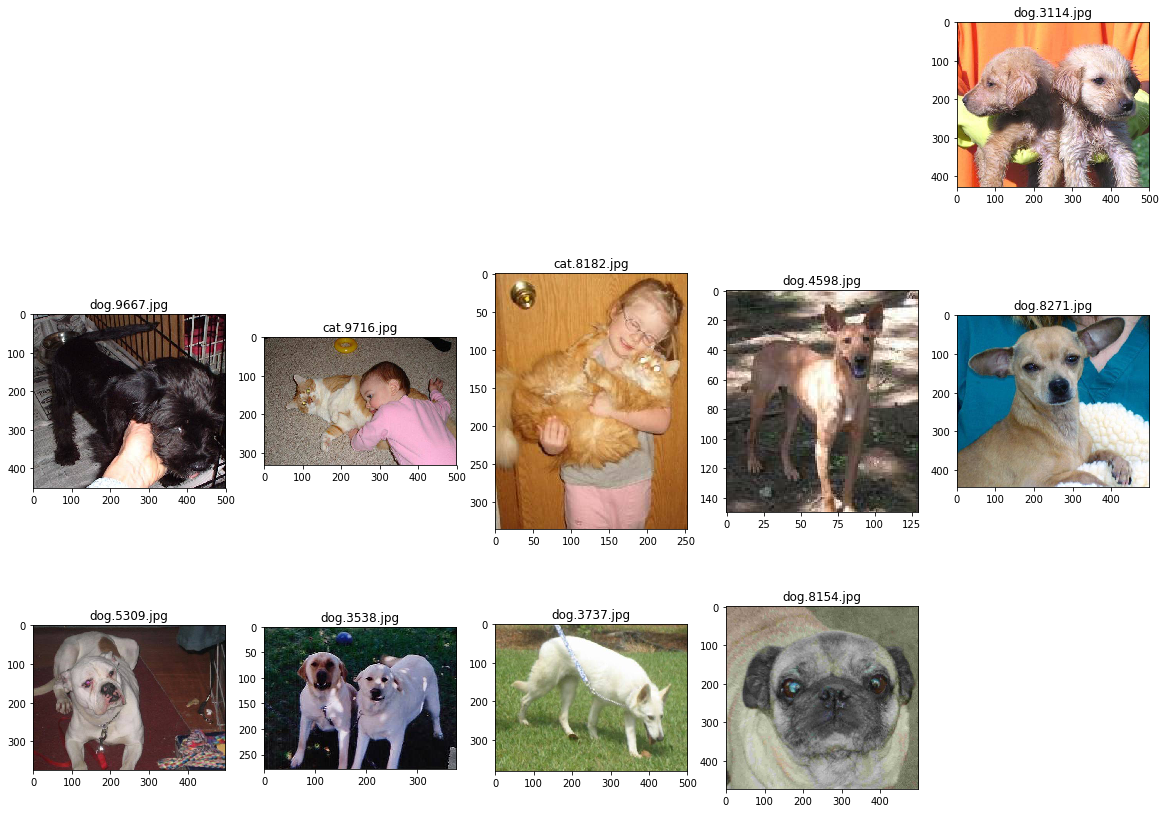

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path.split('/')[-1]);

## Загружаем предобученную модель

In [8]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

94658560/94653016 [==============================] - 85s 1us/step


In [32]:
# # base_model -  объект класса keras.models.Model (Functional Model)
# base_model = VGG16(include_top = False,
#                    weights = 'imagenet',
#                    input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

In [9]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

In [10]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

## Добавляем сверточные слои

In [18]:
x = base_model.layers[-2].output
x = keras.layers.Conv2D(50, (1, 1), kernel_initializer='random_uniform', activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Conv2D(50, (3, 3), kernel_initializer='random_uniform', activation='relu')(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1, kernel_initializer='random_uniform', activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=x)

## Выводим архитектуру модели

In [20]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

## Компилируем модель и запускаем обучение

In [21]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.0001), 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [24]:
shuffle(train_files)  # перемешиваем обучающую выборку

train_val_split = 100  # число изображений в валидационной выборке

validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))

In [25]:
# запускаем процесс обучения
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=50,  # число вызовов генератора за эпоху
        epochs=30,  # число эпох обучения
        validation_data=validation_data)

Epoch 1/30
50/50 [==============================] - 774s 15s/step - loss: 0.6153 - acc: 0.6719 - val_loss: 0.2036 - val_acc: 0.9600
Epoch 2/30
50/50 [==============================] - 737s 15s/step - loss: 0.2444 - acc: 0.9131 - val_loss: 0.1104 - val_acc: 0.9600
Epoch 3/30
50/50 [==============================] - 738s 15s/step - loss: 0.1687 - acc: 0.9300 - val_loss: 0.0933 - val_acc: 0.9500
Epoch 4/30
50/50 [==============================] - 738s 15s/step - loss: 0.1383 - acc: 0.9487 - val_loss: 0.0756 - val_acc: 0.9700
Epoch 5/30
50/50 [==============================] - 743s 15s/step - loss: 0.1098 - acc: 0.9569 - val_loss: 0.1067 - val_acc: 0.9800
Epoch 6/30
50/50 [==============================] - 740s 15s/step - loss: 0.1058 - acc: 0.9613 - val_loss: 0.0676 - val_acc: 0.9700
Epoch 7/30
50/50 [==============================] - 736s 15s/step - loss: 0.1158 - acc: 0.9525 - val_loss: 0.0814 - val_acc: 0.9700
Epoch 8/30
50/50 [==============================] - 740s 15s/step - loss: 0.

In [6]:
from keras.models import load_model

In [9]:
model = load_model("./ResNet50.model")

In [ ]:
model.save('ResNet50.model')

## Предсказания на проверочной выборке

In [10]:
pred = model.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500)

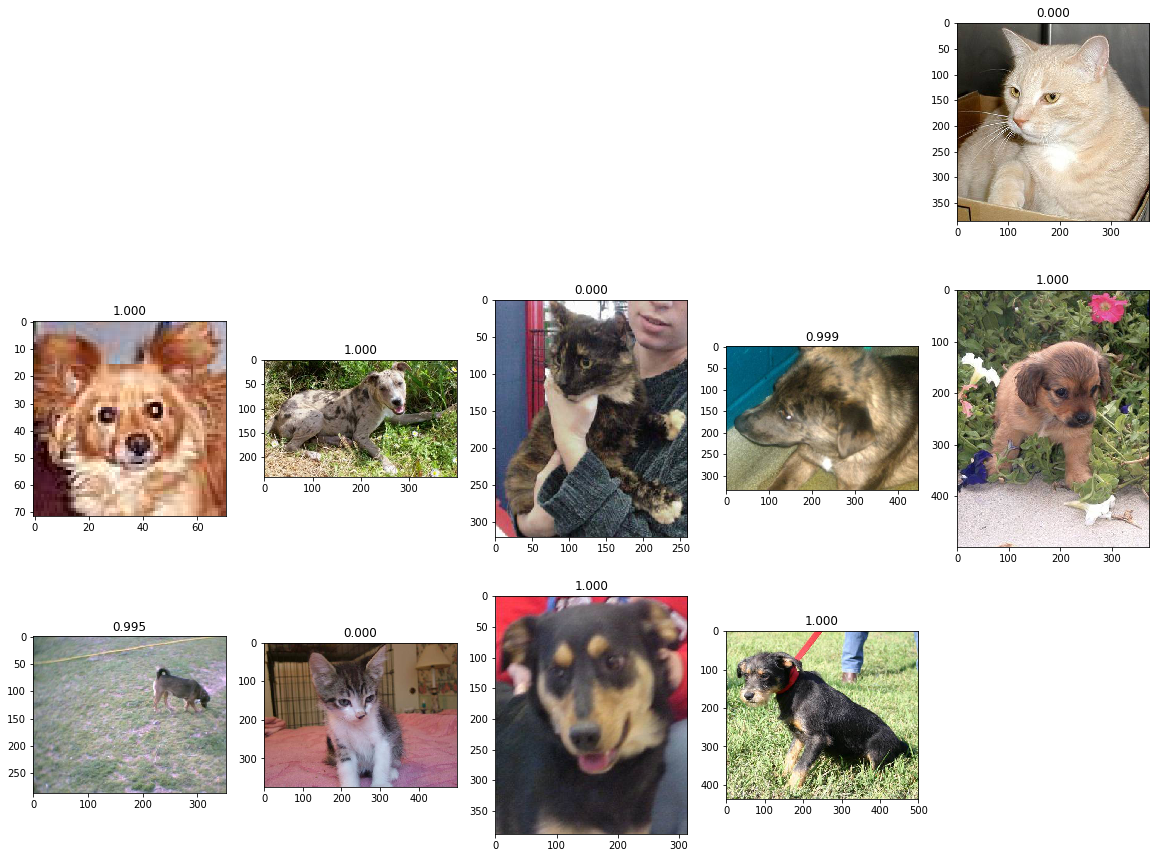

In [11]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(test_files[80:][:10], pred[80:][:10]), 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%.3f' % score);

## Готовим данные для сабмита

In [12]:
with open('submit_1.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, pred):
        dst.write('%s,%f\n' % (re.search('(\d+)', path).group(0), score))

![submit](submit.png)